In [1]:
! git clone https://github.com/shane200195/Stock_ml.git

Cloning into 'Stock_ml'...
remote: Enumerating objects: 559, done.
remote: Counting objects: 100% (559/559), done.
remote: Compressing objects: 100% (553/553), done.
remote: Total 559 (delta 8), reused 557 (delta 6), pack-reused 0
Receiving objects: 100% (559/559), 16.91 MiB | 18.00 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [2]:
! ls

sample_data  Stock_ml


In [4]:
import pandas as pd
import numpy as np

djia = pd.read_csv("Stock_ml/dija.csv")
djia = djia.set_index("Date")


for column in djia.columns:
  djia[column + "Volatile?"] = [1 if abs(i) > 0.01 else 0 for i in djia[column]]

# feature selection
target = "MSFT" # stock we want to test correlation with
features = [i for i in djia.columns if "Volatile?" in i and target not in i] #selecting the columns with volatility

x = djia.loc[:,features].values
#selecting the target that will be used to classify a particular state
result = djia[target + "Volatile?"].values
print(result)

[1 0 0 ... 0 0 0]


In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)

print(principal_components)

[[ 1.15124854 -0.29717708]
 [ 0.51168805  0.51185435]
 [-0.18189909 -0.87498709]
 ...
 [-1.8336389   0.34362213]
 [-1.8336389   0.34362213]
 [-0.90943642  0.21295326]]


In [7]:
principalDf = pd.DataFrame(data = principal_components
             , columns = ['component 1', 'component 2'])

# converting the index of result
result = pd.DataFrame(data = result, columns=["Result"])
finalDf = pd.concat([principalDf, result], axis = 1)
print(finalDf)

      component 1  component 2  Result
0        1.151249    -0.297177       1
1        0.511688     0.511854       0
2       -0.181899    -0.874987       0
3       -0.334269    -0.468416       0
4        0.187810     0.586191       0
...           ...          ...     ...
3014    -1.454558     0.532375       0
3015    -1.533059     0.042790       0
3016    -1.833639     0.343622       0
3017    -1.833639     0.343622       0
3018    -0.909436     0.212953       0

[3019 rows x 3 columns]


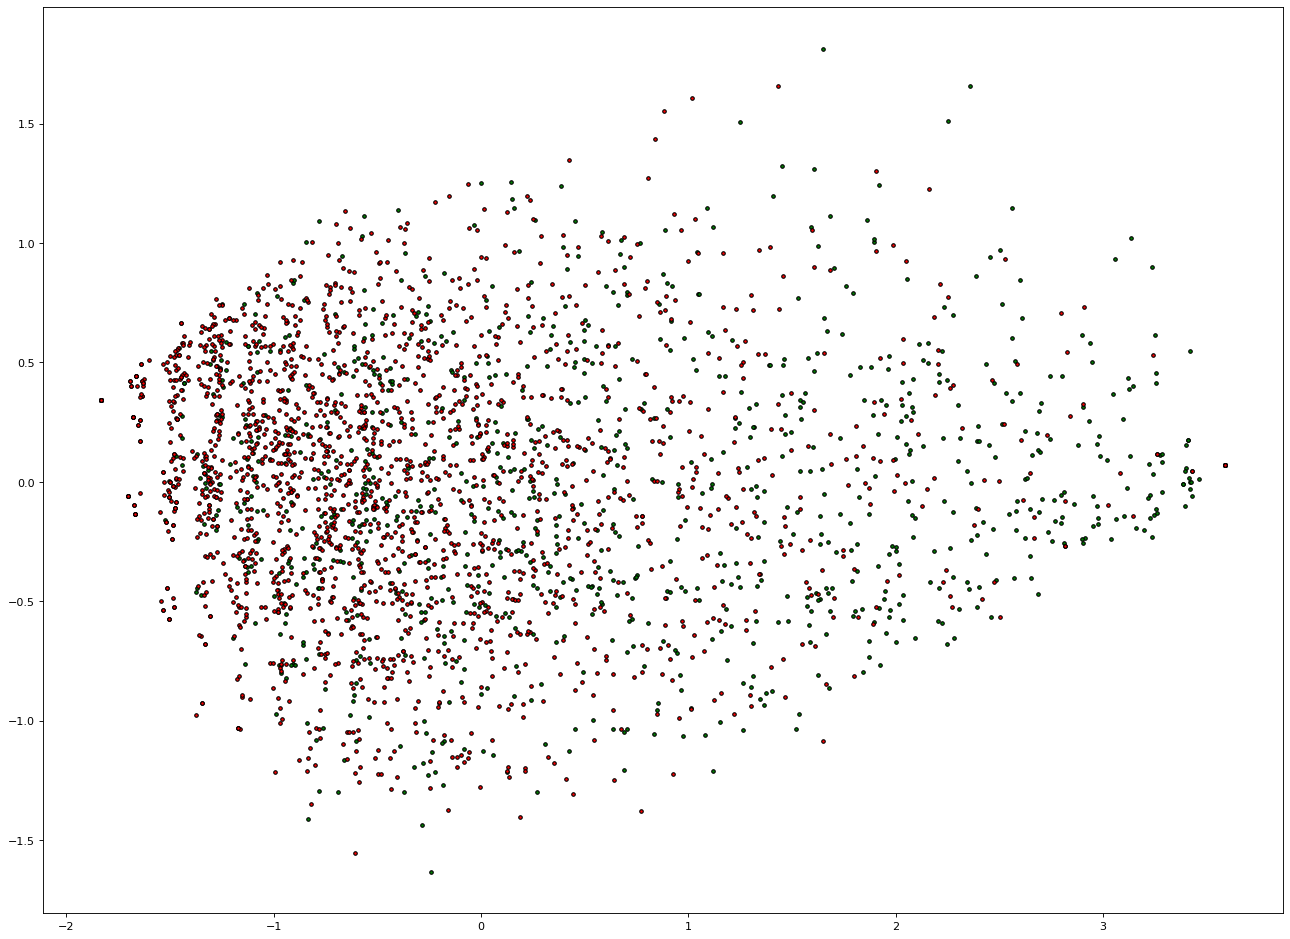

In [67]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 15), dpi=80, facecolor='w', edgecolor='k')
targets = [1, 0]
colors = ['g', 'r']

# graphing the data after PCA, the red color represents a 0 (low volatility), while the green represents a 1 (high volatility)
for target, color in zip(targets, colors):
  indicesToKeep = finalDf["Result"] == target
  plt.scatter(finalDf.loc[indicesToKeep, 'component 1']
               , finalDf.loc[indicesToKeep, 'component 2']
               , c = color
               , s = 10, edgecolor="k")
# plt.scatter(principalDf["component 1"], principalDf["component 2"])
plt.show()


Training SVM model for S&P500 dataset

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

SVM_djia = SVC(gamma="auto")

# uses all 6 stocks
# X_train, X_test, y_train, y_test = train_test_split(x, result, test_size=0.5, random_state=42)

# stocks that have been component reduced
#X_train, X_test, y_train, y_test = train_test_split(finalDf.loc[:, ['component 1', 'component 2']].values, result, test_size=0.5, random_state=42)

SVM_djia.fit(X_train, y_train)

print(SVM_djia.score(X_train, y_train))
print(SVM_djia.score(X_test, y_test))





/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7375745526838966
0.7350993377483444


Training a KNN model for S&P500 dataset

In [0]:
from sklearn.neighbors import KNeighborsClassifier

KNN_djia = KNeighborsClassifier(n_neighbors=10)
KNN_djia.fit(X_train, y_train)
#predictions = KNN_sp500.predict(X_test)
#accuracy_score(predictions, y_test)
print(KNN_djia.score(X_train, y_train))
print(KNN_djia.score(X_test, y_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


0.7263088137839628
0.7311258278145696


Logistic Regression for S&P500 dataset

In [0]:
from sklearn.linear_model import LogisticRegression

LR_djia = LogisticRegression()
LR_djia.fit(X_train, y_train)

print(LR_djia.score(X_train, y_train))
print(LR_djia.score(X_test, y_test))

0.7335984095427436
0.7258278145695364


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Now we will try to build a recurrent neural network, with LSTM to see if it can fit the data better.

In [66]:
print(len(x))

# we need to segregate the new data
split = 2000

X_train = x[:split]
Y_train = result[:split]

X_test = x[split:]
Y_test = result[split:]

#importing the modules needed for the neural network
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, GRU

lstm_units = 6
X_train_t = X_train[:, None]
X_test_t = X_test[:, None]
K.clear_session()

model = Sequential()
model.add(LSTM(6, input_shape=(1, 30)))
model.add(Dense(1))

#Using Keras Callback
ES = EarlyStopping(monitor='val_loss')

model.compile(loss='mean_absolute_error', optimizer='adam')
#model.fit(X_train_t, Y_train,
#         epochs=10, batch_size=1, verbose=1, callbacks=[ES], validation_data = (X_test_t, Y_test))

model.fit(X_train_t, Y_train,
         epochs=7, batch_size=1, verbose=1, validation_data = (X_test_t, Y_test))

y_train_lstm = model.predict_classes(X_train_t)
y_test_lstm = model.predict_classes(X_test_t)

print(accuracy_score(Y_train, y_train_lstm))
print(accuracy_score(Y_test, y_test_lstm))



"""
WE WILL USE THIS SECTION TO SEE HOW OUR MODEL VARIES:

loss = "mean_squared_error", epochs = 4, 2500/519 split
Train: 0.7256
Test: 0.7880539499036608

loss = "mean_absolute_error", epochs = 13, 2500/519 split
Train: 0.726
Test: 0.7861271676300579

"""


3019
Train on 2000 samples, validate on 1019 samples
Epoch 1/7
2000/2000 [==============================] - 6s 3ms/step - loss: 0.3658 - val_loss: 0.2848
Epoch 2/7
2000/2000 [==============================] - 6s 3ms/step - loss: 0.3342 - val_loss: 0.2708
Epoch 3/7
2000/2000 [==============================] - 6s 3ms/step - loss: 0.3173 - val_loss: 0.2694
Epoch 4/7
2000/2000 [==============================] - 6s 3ms/step - loss: 0.3117 - val_loss: 0.2733
Epoch 5/7
2000/2000 [==============================] - 6s 3ms/step - loss: 0.3081 - val_loss: 0.2694
Epoch 6/7
2000/2000 [==============================] - 6s 3ms/step - loss: 0.3050 - val_loss: 0.2666
Epoch 7/7
2000/2000 [==============================] - 6s 3ms/step - loss: 0.3048 - val_loss: 0.2656
0.7285
0.7526987242394504


'\nWE WILL USE THIS SECTION TO SEE HOW OUR MODEL VARIES:\n\nloss = "mean_squared_error", epochs = 4, 2500/519 split\nTrain: 0.7256\nTest: 0.7880539499036608\n\nloss = "mean_absolute_error", epochs = 13\nTrain: 0.726\nTest: 0.7861271676300579\n\n'